In [59]:
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import sf_quant.data as sfd
import sf_quant.optimizer as sfo
from tqdm import tqdm
import datetime as dt

In [10]:
alpha_data = pl.read_parquet("../signal_weights/signal_data.parquet").with_columns(pl.col('return').shift(-1).over('barrid').alias('fwd_return'))

alpha_data

date,barrid,ticker,price,return,specific_return,specific_risk,historical_beta,predicted_beta,market_cap,daily_volume,bid_ask_spread,log_return,momentum,meanrev,bab,momentum_z,meanrev_z,bab_z,momentum_alpha,meanrev_alpha,bab_alpha,fwd_return
date,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2013-07-31,"""USA06Z1""","""MDXG""",6.26,-0.001595,-0.00788,0.550569,0.328385,0.34349,6.006157e8,121693.0,0.01,-0.001596,null,null,-0.34349,null,null,2.149267,null,null,0.059166,0.009585
2013-08-01,"""USA06Z1""","""MDXG""",6.32,0.009585,0.00365,0.55028,0.334989,0.353329,6.0865392e8,131728.0,0.01,0.009539,null,null,-0.353329,null,null,2.111728,null,null,0.058102,-0.001582
2013-08-02,"""USA06Z1""","""MDXG""",6.31,-0.001582,-0.00731,0.548074,0.330713,0.363624,6.0769086e8,43252.0,0.01,-0.001583,null,null,-0.363624,null,null,2.086144,null,null,0.057168,0.022187
2013-08-05,"""USA06Z1""","""MDXG""",6.45,0.022187,0.01936,0.547667,0.324494,0.356596,6.211737e8,70944.0,0.02,0.021944,null,null,-0.356596,null,null,2.098288,null,null,0.057458,-0.024806
2013-08-06,"""USA06Z1""","""MDXG""",6.29,-0.024806,-0.00528,0.546922,0.366323,0.399196,6.0576474e8,77085.0,0.01,-0.025119,null,null,-0.399196,null,null,2.001238,null,null,0.054726,-0.081081
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-09-09,"""USBRKA2""","""GLIBA""",36.225,-0.004261,0.01121,0.208427,0.236481,0.302514,1.3226e8,31025.0,0.11,-0.00427,null,-0.007341,-0.302514,null,0.37369,2.013268,null,0.003894,0.020981,0.000414
2025-09-10,"""USBRKA2""","""GLIBA""",36.24,0.000414,0.02305,0.209547,0.252015,0.29845,1.3231e8,6298.0,0.21,0.000414,null,-0.020066,-0.29845,null,0.247624,2.007619,null,0.002594,0.021035,0.022351
2025-09-11,"""USBRKA2""","""GLIBA""",37.05,0.022351,0.00213,0.214807,0.256752,0.31384,1.3527e8,26857.0,0.25,0.022105,null,-0.065239,-0.31384,null,0.07841,1.987568,null,0.000842,0.021347,-0.023752


In [5]:
weights_data = pl.read_parquet("../signal_weights/weights/updated_weights_pivot.parquet")

weights_data

date,barrid,bab_weight,meanrev_weight,momentum_weight
date,str,f64,f64,f64
1995-06-30,"""USAA191""",-1.0844e-20,null,null
1995-06-30,"""USAA1W1""",-9.1201e-22,null,null
1995-06-30,"""USAA1Y1""",-4.8273e-21,null,null
1995-06-30,"""USAA2L1""",-4.2673e-21,null,null
1995-06-30,"""USAA311""",-9.2198e-21,null,null
…,…,…,…,…
2025-09-15,"""USBQZR1""",-6.9890e-22,-1.3553e-20,null
2025-09-15,"""USBRGT1""",-3.7165e-21,-3.4045e-19,null
2025-09-15,"""USBRH21""",-2.6956e-21,-9.9263e-20,null


In [11]:
df = alpha_data.join(weights_data, on=["date", "barrid"], how="inner").select(['date', 'barrid', 'return', 'fwd_return', 'predicted_beta', 'momentum_alpha', 'meanrev_alpha', 'bab_alpha', 'momentum_weight', 'meanrev_weight', 'bab_weight'])

df

date,barrid,return,fwd_return,predicted_beta,momentum_alpha,meanrev_alpha,bab_alpha,momentum_weight,meanrev_weight,bab_weight
date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
1995-06-30,"""USAA191""",0.051471,-0.013986,0.823795,null,null,0.003645,null,null,-1.0844e-20
1995-06-30,"""USAA1W1""",0.057971,0.0,1.105022,null,null,-0.010093,null,null,-9.1201e-22
1995-06-30,"""USAA1Y1""",0.028777,-0.017483,1.636947,null,null,-0.027408,null,null,-4.8273e-21
1995-06-30,"""USAA2L1""",0.036585,0.002941,0.725292,null,null,0.010805,null,null,-4.2673e-21
1995-06-30,"""USAA311""",0.020134,-0.006579,0.798643,null,null,0.005402,null,null,-9.2198e-21
…,…,…,…,…,…,…,…,…,…,…
2025-09-15,"""USBQZR1""",-0.041651,null,1.365701,null,-0.159387,-0.024335,null,-1.3553e-20,-6.9890e-22
2025-09-15,"""USBRGT1""",0.0,null,1.264243,null,0.012975,-0.005506,null,-3.4045e-19,-3.7165e-21
2025-09-15,"""USBRH21""",0.011281,null,1.364664,null,-0.003457,-0.019368,null,-9.9263e-20,-2.6956e-21


In [33]:
momentum_alphas = df.group_by('date').agg((pl.col('momentum_alpha') * pl.col('momentum_weight')).sum().alias('momentum')).sort('date')
meanrev_alphas = df.group_by('date').agg((pl.col('meanrev_alpha') * pl.col('meanrev_weight')).sum().alias('meanrev')).sort('date')
bab_alphas = df.group_by('date').agg((pl.col('bab_alpha') * pl.col('bab_weight')).sum().alias('bab')).sort('date')

alphas = momentum_alphas.join(meanrev_alphas, on=["date"], how="inner").join(bab_alphas, on=["date"], how="inner")

alphas = alphas.unpivot(
    index=["date"],
    on=["momentum", "meanrev", "bab"],
    variable_name="portfolio",
    value_name="alpha"   
)

alphas

date,portfolio,alpha
date,str,f64
1995-06-30,"""momentum""",0.0
1995-07-03,"""momentum""",0.0
1995-07-05,"""momentum""",0.0
1995-07-06,"""momentum""",0.0
1995-07-07,"""momentum""",0.0
…,…,…
2025-09-09,"""bab""",0.011151
2025-09-10,"""bab""",0.010666
2025-09-11,"""bab""",0.011057


In [32]:
momentum_fwd_returns = df.group_by('date').agg((pl.col('fwd_return') * pl.col('momentum_weight')).sum().alias('momentum')).sort('date')
meanrev_fwd_returns = df.group_by('date').agg((pl.col('fwd_return') * pl.col('meanrev_weight')).sum().alias('meanrev')).sort('date')
bab_fwd_returns = df.group_by('date').agg((pl.col('fwd_return') * pl.col('bab_weight')).sum().alias('bab')).sort('date')

fwd_returns = momentum_fwd_returns.join(meanrev_fwd_returns, on=["date"], how="inner").join(bab_fwd_returns, on=["date"], how="inner")
fwd_returns = fwd_returns.unpivot(
    index=["date"],                    # columns to keep as-is
    on=["momentum", "meanrev", "bab"],  # columns to unpivot
    variable_name="portfolio",          # name for new column with old column names
    value_name="fwd_return"             # name for new column with values
)

fwd_returns

date,portfolio,fwd_return
date,str,f64
1995-06-30,"""momentum""",0.0
1995-07-03,"""momentum""",0.0
1995-07-05,"""momentum""",0.0
1995-07-06,"""momentum""",0.0
1995-07-07,"""momentum""",0.0
…,…,…
2025-09-09,"""bab""",-0.001612
2025-09-10,"""bab""",0.01412
2025-09-11,"""bab""",-0.002666


In [35]:
portfolio_data = alphas.join(fwd_returns, on=['date', 'portfolio'], how='inner').sort('date')

portfolio_data

date,portfolio,alpha,fwd_return
date,str,f64,f64
1995-06-30,"""momentum""",0.0,0.0
1995-06-30,"""meanrev""",0.0,0.0
1995-06-30,"""bab""",0.007734,0.003396
1995-07-03,"""momentum""",0.0,0.0
1995-07-03,"""meanrev""",0.0,0.0
…,…,…,…
2025-09-12,"""meanrev""",0.09756,-0.011655
2025-09-12,"""bab""",0.010894,0.008112
2025-09-15,"""momentum""",0.153725,0.0


In [ ]:
portfolio_data_wide = portfolio_data.pivot(
    values="fwd_return",
    index="date",
    on="portfolio"
).sort("date")

dates = portfolio_data_wide["date"].to_numpy()
returns_matrix = portfolio_data_wide.drop("date").to_numpy()  # shape: (n_days, n_portfolios)
portfolios = portfolio_data_wide.drop("date").columns

rolling_window = 2
cov_matrices = {}
weights = {}

for i in tqdm(range(rolling_window, len(dates))):
    window_returns = returns_matrix[i - rolling_window : i, :]
    cov_matrix = np.cov(window_returns, rowvar=False)
    cov_matrices[dates[i]] = cov_matrix
    constraints = [
        sfo.FullInvestment(),
        sfo.LongOnly(),
        sfo.NoBuyingOnMargin(),
        # sfo.UnitBeta()
    ]

    target_date = dates[i].astype("M8[D]").astype(object)  # convert numpy.datetime64[D] → datetime.date
    alpha_vector = portfolio_data.filter(pl.col('date').eq(target_date)).select('alpha').to_numpy()

    weights[dates[i]] = sfo.mve_optimizer(
        ids=["momentum", "meanrev", "bab"],
        alphas=alpha_vector,
        covariance_matrix=cov_matrix,
        constraints=constraints,
        gamma=2
    )


  0%|          | 0/7600 [00:00<?, ?it/s]

100%|██████████| 7600/7600 [01:10<00:00, 108.20it/s]


In [57]:
weights_list = []
for date_, df in weights.items():
    # Convert numpy.datetime64 → Python date
    if isinstance(date_, np.datetime64):
        date_ = date_.astype("M8[D]").astype(object)  # ensures it's a datetime.date
    
    # If still a datetime, convert down to date
    if isinstance(date_, dt.datetime):
        date_ = date_.date()
    
    df_with_date = df.with_columns(
        pl.lit(date_).alias("date").cast(pl.Date)
    )
    weights_list.append(df_with_date)

weights_all = pl.concat(weights_list)
weights_all = weights_all.rename({'barrid': 'portfolio'})
portfolio_data = portfolio_data.join(weights_all, on=['date', 'portfolio'], how='inner')

In [58]:
synMVO_ret = portfolio_data.group_by('date').agg((pl.col('fwd_return') * pl.col('weight')).sum().alias('fwd_return'))

synMVO_ret

date,fwd_return
date,f64
1995-07-05,0.015761
1995-07-06,0.013632
1995-07-07,0.007163
1995-07-10,-0.001239
1995-07-11,0.015558
…,…
2025-09-09,-0.013806
2025-09-10,0.021175
2025-09-11,0.012507


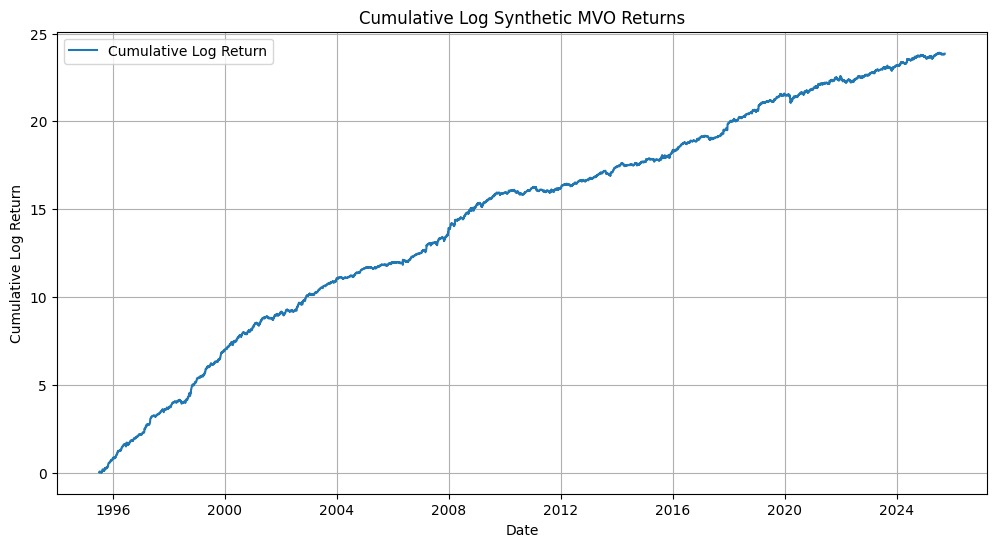

In [64]:
# Calculate cumulative returns
synMVO_cum_ret = ( 
    synMVO_ret.with_columns(
    pl.col('fwd_return').log1p().alias('log_return')
    )
    .with_columns(
    pl.col('log_return').cum_sum().alias('cum_log_return')
    )
)

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(synMVO_cum_ret["date"], synMVO_cum_ret["cum_log_return"], label="Cumulative Log Return")
plt.title("Cumulative Log Synthetic MVO Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.show()

In [65]:
def compute_sharpe_ratio(df: pl.DataFrame, return_col: str = "eqWtRet") -> float:
    """
    Compute annualized Sharpe ratio from daily portfolio returns.
    
    Args:
        df (pl.DataFrame): Must contain one row per date with a return column in decimal space.
        return_col (str): Column containing daily returns.
    
    Returns:
        float: Annualized Sharpe ratio.
    """
    # Extract daily returns
    daily_rets = df[return_col].to_numpy()

    mean_return = daily_rets.mean()
    std_return = daily_rets.std(ddof=1)

    # Annualized Sharpe (sqrt(252) for daily frequency)
    sharpe_annualized = (mean_return / std_return) * np.sqrt(252)

    return sharpe_annualized

In [66]:
compute_sharpe_ratio(synMVO_cum_ret, return_col='fwd_return')

np.float64(2.5457595061977876)